In [1]:
# pip install adtk

In [2]:
# pip install deel

In [3]:
# pip install puncc

In [4]:
import pandas as pd
import numpy as np
import os
import yfinance as yf
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from deel.puncc.anomaly_detection import SplitCAD
from deel.puncc.api.prediction import BasePredictor
from adtk.detector import QuantileAD, ThresholdAD, GeneralizedESDTestAD, RegressionAD, InterQuartileRangeAD
from adtk.visualization import plot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
pio.renderers.default = 'colab'

In [5]:
import numpy as np
import os # not needed for Mac
os.add_dll_directory('C:\Aorda\PSG\lib') # not needed for Mac
import psgpython as psg 
from matplotlib import pyplot as plt
import yfinance as yf
from bokeh.plotting import figure, show, output_notebook
from bokeh.io import output_file
output_notebook()
import pandas as pd

Loading BokehJS ...

In [6]:
import numpy as np
import yfinance as yf

df = yf.download('^DJI', start='2020-01-01', end='2024-10-31')
df = df['Volume']
df1 = df.reset_index()
df1.rename(columns={"^DJI": "Volume"}, inplace=True)
df1['Volume']=df1['Volume']/1000000
print(df1.shape)
df1.head()

[*********************100%%**********************]  1 of 1 completed

(1216, 2)


,Date,Volume
0,2020-01-02,251.82
1,2020-01-03,239.59
2,2020-01-06,252.76
3,2020-01-07,258.90
4,2020-01-08,291.75


In [7]:
df1['Date']=pd.to_datetime(df1['Date'])
df_train = df1[(df1['Date'] >= '2020-01-01') & (df1['Date'] <= '2023-12-31')]
df_test = df1[(df1['Date'] >= '2024-01-01')]

print("Train Data Shape:", df_train.shape)
print("Test Data Shape:", df_test.shape)

df_train["Flag"] = np.where((df_train["Volume"] >= 250) & (df_train["Volume"] <= 500), 0, 1)
df_test["Flag"] = np.where((df_test["Volume"] >= 250) & (df_test["Volume"] <= 500), 0, 1)

df1=pd.concat([df_train,df_test],axis=0)
print("Train Data : ",df_train['Flag'].value_counts())
print("Test Data : ",df_test['Flag'].value_counts())

Train Data Shape: (1006, 2)
Test Data Shape: (210, 2)
Train Data :  Flag
0    861
1    145
Name: count, dtype: int64
Test Data :  Flag
0    197
1     13
Name: count, dtype: int64


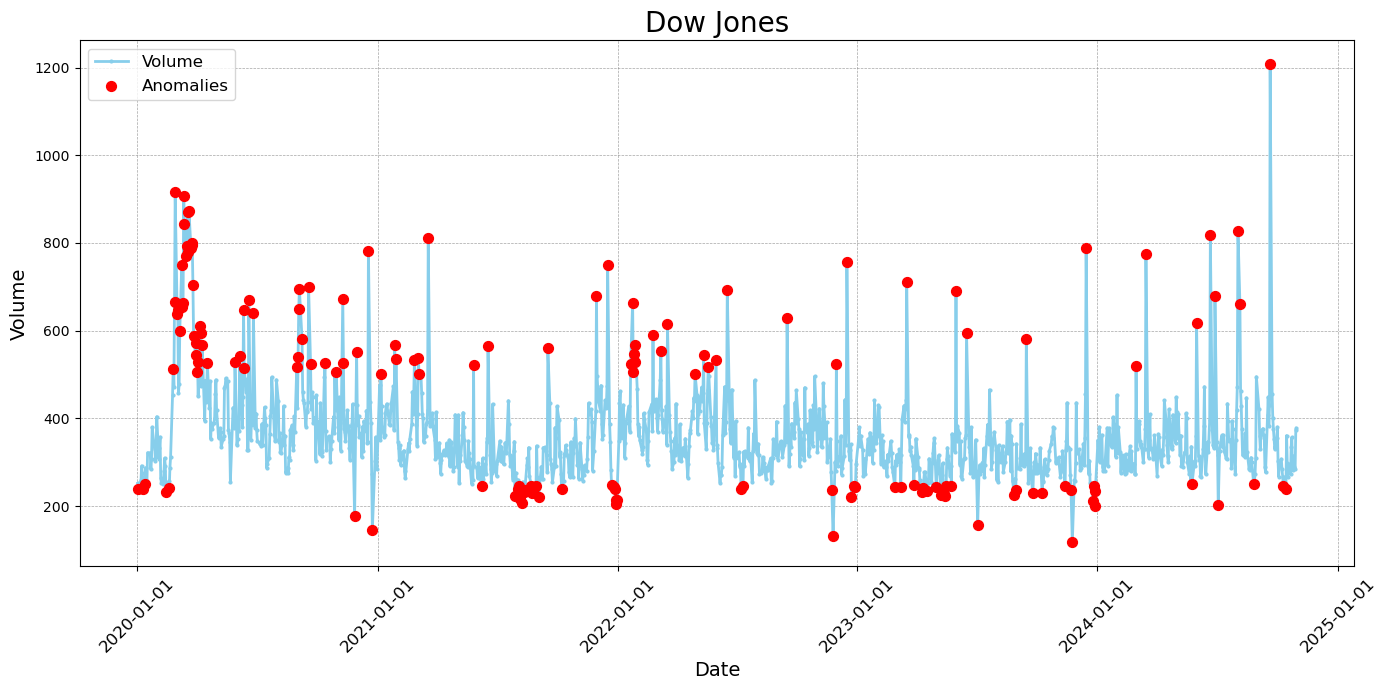

In [8]:
df1['Date'] = pd.to_datetime(df1['Date'])

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(df1['Date'], df1['Volume'], label='Volume', color='skyblue', linewidth=2, marker='o', markersize=2)
anomalies = df1[df1['Flag'] == 1]
ax.scatter(anomalies['Date'], anomalies['Volume'], label='Anomalies', color='red', s=50, zorder=5)
ax.set_title('Dow Jones', fontsize=20, color='black')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Volume', fontsize=14)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(fontsize=12, rotation=45)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax.legend(fontsize=12, framealpha=0.8)
plt.tight_layout()
plt.show()

In [9]:
def create_lagged_features(data, lags=30):
    df = data.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['Volume'].shift(lag)
    return df
lagged_df = create_lagged_features(df1, lags=30)
lagged_df = lagged_df.dropna()
df_train = lagged_df[lagged_df['Date'] < '2024-01-01']
df_test = lagged_df[lagged_df['Date'] >= '2024-01-01']
df_train["Flag"] = np.where((df_train["Volume"] >= 250) & (df_train["Volume"] <= 500), 0, 1)
df_test["Flag"] = np.where((df_test["Volume"] >= 250) & (df_test["Volume"] <= 500), 0, 1)
df_test.head()

,Date,Volume,Flag,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
1006,2024-01-02,350.28,0,234.57,199.55,245.53,212.42,252.97,253.12,303.45,...,435.54,299.33,256.21,258.34,117.04,237.29,271.12,331.05,334.82,435.54
1007,2024-01-03,322.01,0,350.28,234.57,199.55,245.53,212.42,252.97,253.12,...,321.84,435.54,299.33,256.21,258.34,117.04,237.29,271.12,331.05,334.82
1008,2024-01-04,380.22,0,322.01,350.28,234.57,199.55,245.53,212.42,252.97,...,329.45,321.84,435.54,299.33,256.21,258.34,117.04,237.29,271.12,331.05
1009,2024-01-05,299.48,0,380.22,322.01,350.28,234.57,199.55,245.53,212.42,...,309.25,329.45,321.84,435.54,299.33,256.21,258.34,117.04,237.29,271.12
1010,2024-01-08,362.20,0,299.48,380.22,322.01,350.28,234.57,199.55,245.53,...,283.24,309.25,329.45,321.84,435.54,299.33,256.21,258.34,117.04,237.29


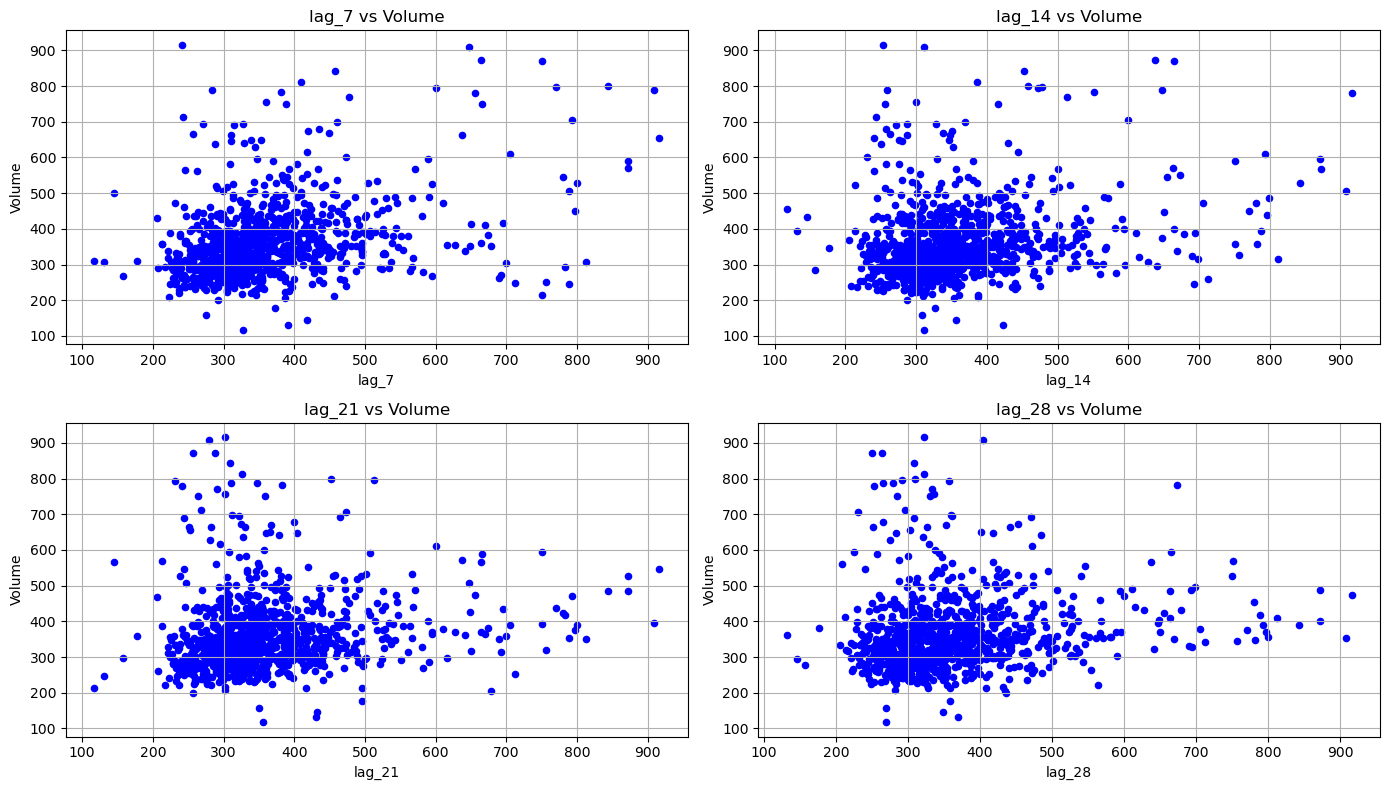

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
lags = ['lag_7', 'lag_14', 'lag_21', 'lag_28']
for i, lag in enumerate(lags):
    row, col = divmod(i, 2)
    axes[row, col].scatter(df_train[lag], df_train['Volume'], color='blue',s=20)
    axes[row, col].set_title(f'{lag} vs Volume')
    axes[row, col].set_xlabel(lag)
    axes[row, col].set_ylabel('Volume')
    axes[row, col].grid(True)
plt.tight_layout()
plt.show()

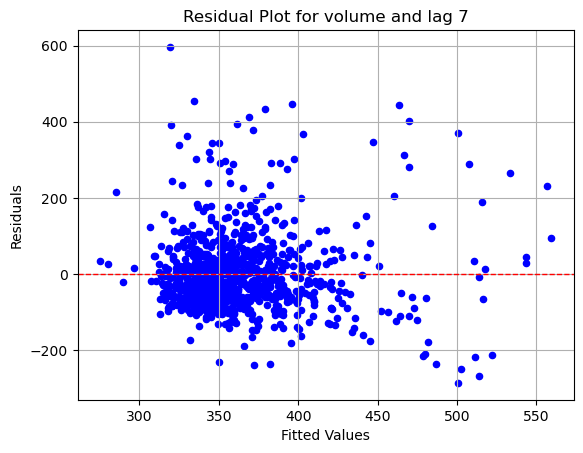

In [11]:
from statsmodels.stats.diagnostic import het_breuschpagan

X = df_train[['lag_7']]
y = df_train['Volume']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
residuals = model.resid
plt.scatter(model.fittedvalues, residuals, color='blue', s=20)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residual Plot for volume and lag 7')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

In [12]:
df_train.head()

,Date,Volume,Flag,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
30,2020-02-14,231.00,1,291.15,309.53,279.54,250.51,252.86,263.70,357.54,...,260.27,287.44,249.83,237.83,275.06,291.75,258.90,252.76,239.59,251.82
31,2020-02-18,256.60,0,231.00,291.15,309.53,279.54,250.51,252.86,263.70,...,252.11,260.27,287.44,249.83,237.83,275.06,291.75,258.90,252.76,239.59
32,2020-02-19,240.64,1,256.60,231.00,291.15,309.53,279.54,250.51,252.86,...,321.82,252.11,260.27,287.44,249.83,237.83,275.06,291.75,258.90,252.76
33,2020-02-20,287.78,0,240.64,256.60,231.00,291.15,309.53,279.54,250.51,...,320.64,321.82,252.11,260.27,287.44,249.83,237.83,275.06,291.75,258.90
34,2020-02-21,311.21,0,287.78,240.64,256.60,231.00,291.15,309.53,279.54,...,283.44,320.64,321.82,252.11,260.27,287.44,249.83,237.83,275.06,291.75


In [13]:
train=df_train[['lag_7','Volume']]
test=df_test[['lag_7','Volume']]

In [14]:
train['intercept']=1.00E+00
train.rename(columns={"Volume":"scenario_benchmark"},inplace=True)
train=train[["intercept","scenario_benchmark","lag_7"]]
train.head()

,intercept,scenario_benchmark,lag_7
30,1.0,231.00,357.54
31,1.0,256.60,263.70
32,1.0,240.64,252.86
33,1.0,287.78,250.51
34,1.0,311.21,279.54


In [15]:
test['intercept']=1.00E+00
test.rename(columns={"Volume":"scenario_benchmark"},inplace=True)
test=test[["intercept","scenario_benchmark","lag_7"]]
test.head()

,intercept,scenario_benchmark,lag_7
1006,1.0,350.28,303.45
1007,1.0,322.01,253.12
1008,1.0,380.22,252.97
1009,1.0,299.48,212.42
1010,1.0,362.20,245.53


In [16]:
train = train.reset_index(drop=True)

train = train.apply(pd.to_numeric, errors='coerce')

folder_name = 'qr_psg'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Save the combined data to a .txt file without date
file_path = os.path.join(folder_name, "matrix_style_classification.txt")
train.to_csv(file_path, sep='\t', index=False, header=True)

In [17]:
quantile_25 = """
minimize
  kb_err(0.75, matrix_style_classification)
"""

file_path_opt = "qr_psg/problem_kb_err_style_classification_25.txt"

with open(file_path_opt, 'w') as file:
    file.write(quantile_25)

In [18]:
quantile_75 = """
minimize
  kb_err(0.25, matrix_style_classification)
"""

file_path_opt = "qr_psg/problem_kb_err_style_classification_75.txt"

with open(file_path_opt, 'w') as file:
    file.write(quantile_75)

In [19]:
# Import the problem
allowExternal = True
suppressMessages = False
path_from_import = r"C:\Users\Ajeet Rai\OneDrive\Desktop\SBU\Academics\Sem II\AMS 518 Advanced Stochastic Models, Risk Assessment, and Portfolio Optimization\Final\qr_psg\problem_kb_err_style_classification_25.txt" # specify a path to the file which name starts with problem (not smth else)

problem_dictionary = psg.psg_importfromtext(path_from_import, suppressMessages) # the result is a dictionary
print(problem_dictionary)

OK. Problem Imported

{'problem_name': 'problem_1', 'problem_statement': '\nminimize\n  kb_err(0.75, matrix_style_classification)\n', 'matrix_style_classification': [['intercept', 'scenario_benchmark', 'lag_7'], array([[  1.  , 231.  , 357.54],
       [  1.  , 256.6 , 263.7 ],
       [  1.  , 240.64, 252.86],
       ...,
       [  1.  , 245.53, 788.16],
       [  1.  , 199.55, 292.12],
       [  1.  , 234.57, 272.74]])]}


In [20]:
# Solve the problem
res = psg.psg_solver(problem_dictionary, allowExternal, suppressMessages) # the result is also a dictionary

Running solver
Reading problem formulation
Asking for data information
Getting data
100% of matrix_style_classification was read
Start optimization
Ext.iteration=0  Objective=0.271969072746E+03  Residual=0.000000000000E+00
Ext.iteration=136  Objective=0.317724670083E+02  Residual=0.000000000000E+00
Optimization is stopped
Solution is feasible
Calculating resulting outputs. Writing solution.
Objective: objective = 31.7724670083 [3.552566192280E-03]
Solver has normally finished. Solution was saved.
Problem: problem_1, solution_status = feasible
Timing: data_loading_time = 0.05, preprocessing_time = 0.01, solving_time = 0.01
Variables: optimal_point = point_problem_1
Objective: objective = 31.7724670083 [3.552566192280E-03]
Function: kb_err(0.75,matrix_style_classification) =  3.177246700830E+01
Function: pseudo_R2_kb_err(0.75,matrix_style_classification) =  9.451142119545E-02
Function: adjusted_pseudo_R2_kb_err(0.75,matrix_style_classification) =  9.544012743012E-02
Function: contributio

In [21]:
q25=res['point_problem_1']
q25

[['intercept', 'lag_7'], array([211.76291709,   0.51505402])]

In [22]:
# Import the problem
allowExternal = True
suppressMessages = False
path_from_import = r"C:\Users\Ajeet Rai\OneDrive\Desktop\SBU\Academics\Sem II\AMS 518 Advanced Stochastic Models, Risk Assessment, and Portfolio Optimization\Final\qr_psg\problem_kb_err_style_classification_75.txt" # specify a path to the file which name starts with problem (not smth else)

#path_from_import=r"C:\Users\Ajeet Rai\Downloads\data_problem_kb_err_style_classification_fidelity_magellan_0p1_short/problem_kb_err_style_classification_fidelity_magellan_0p1_short.txt"
problem_dictionary = psg.psg_importfromtext(path_from_import, suppressMessages) # the result is a dictionary
print(problem_dictionary)

OK. Problem Imported

{'problem_name': 'problem_1', 'problem_statement': '\nminimize\n  kb_err(0.25, matrix_style_classification)\n', 'matrix_style_classification': [['intercept', 'scenario_benchmark', 'lag_7'], array([[  1.  , 231.  , 357.54],
       [  1.  , 256.6 , 263.7 ],
       [  1.  , 240.64, 252.86],
       ...,
       [  1.  , 245.53, 788.16],
       [  1.  , 199.55, 292.12],
       [  1.  , 234.57, 272.74]])]}


In [23]:
# Solve the problem
res = psg.psg_solver(problem_dictionary, allowExternal, suppressMessages) # the result is also a dictionary

Running solver
Reading problem formulation
Asking for data information
Getting data
100% of matrix_style_classification was read
Start optimization
Ext.iteration=0  Objective=0.906563575820E+02  Residual=0.000000000000E+00
Ext.iteration=136  Objective=0.237637488546E+02  Residual=0.000000000000E+00
Optimization is stopped
Solution is feasible
Calculating resulting outputs. Writing solution.
Objective: objective = 23.7637488546 [1.934056666819E-03]
Solver has normally finished. Solution was saved.
Problem: problem_1, solution_status = feasible
Timing: data_loading_time = 0.06, preprocessing_time = 0.01, solving_time = 0.01
Variables: optimal_point = point_problem_1
Objective: objective = 23.7637488546 [1.934056666819E-03]
Function: kb_err(0.25,matrix_style_classification) =  2.376374885455E+01
Function: pseudo_R2_kb_err(0.25,matrix_style_classification) =  3.518241029325E-02
Function: adjusted_pseudo_R2_kb_err(0.25,matrix_style_classification) =  3.617196679551E-02
Function: contributio

In [24]:
q75=res['point_problem_1']
q75

[['intercept', 'lag_7'], array([219.05094905,   0.23269784])]

In [25]:
p = figure(title="Lag 7 vs Volume", 
           x_axis_label='Lag 7', 
           y_axis_label='Volume', 
           width=800, height=600)

p.scatter(x=train['lag_7'], y=train['scenario_benchmark'], size=8, color="red", alpha=0.7)
show(p)

In [41]:
coeffs_25 = q25[1]  
coeffs_75 = q75[1] 
p25 = coeffs_75[0] + coeffs_75[1] * train['lag_7']
p75 = coeffs_25[0] + coeffs_25[1] * train['lag_7']

p = figure(title="25th and 75th Quantile Regression Lines for IBM Returns",
           x_axis_label='Lag 7',
           y_axis_label='Volume', 
           width=800, height=600)

p.scatter(x=train['lag_7'], y=train['scenario_benchmark'], size=8, color="red", legend_label="Data Points")
p.line(train['lag_7'], p25, line_width=2, line_color="blue", legend_label="25th Quantile (IBM)", line_dash="dashed")
p.line(train['lag_7'], p75, line_width=2, line_color="green", legend_label="75th Quantile (IBM)")
p.add_layout(p.legend[0], 'right')
show(p)

In [48]:
p = figure(title="25th and 75th Quantile Regression Lines for IBM Returns",
           x_axis_label='Lag 7',
           y_axis_label='Volume', 
           width=800, height=600)

# Adjusted data points color to blue
p.scatter(x=train['lag_7'], y=train['scenario_benchmark'], size=8, color="blue", legend_label="Data Points")

# 25th quantile regression line (dashed, blue)
p.line(train['lag_7'], p25, line_width=5, line_color="red", legend_label="25th Quantile (IBM)", line_dash="dashed")

# 75th quantile regression line (solid, green)
p.line(train['lag_7'], p75, line_width=5, line_color="green", legend_label="75th Quantile (IBM)")

# Position legend to the right
p.add_layout(p.legend[0], 'right')

show(p)


In [27]:
iqr = p75 - p25
k = .5
f1 = p25 - k * iqr
f2 = p75 + k * iqr
train['f1'] = f1
train['f2'] = f2
train['anomaly_qr'] = np.where((train['scenario_benchmark'] < train['f1']) |
                               (train['scenario_benchmark'] > train['f2']), 1, 0)
train.head()

,intercept,scenario_benchmark,lag_7,f1,f2,anomaly_qr
0,1.0,231.00,357.54,255.416936,442.748131,1
1,1.0,256.60,263.70,246.828723,381.167309,0
2,1.0,240.64,252.86,245.836649,374.053753,1
3,1.0,287.78,250.51,245.621577,372.511608,0
4,1.0,311.21,279.54,248.278395,391.562026,0


In [28]:
train['anomaly_qr'].value_counts()

anomaly_qr
0    762
1    214
Name: count, dtype: int64

In [29]:
df_train['ID'] = range(1, len(df_train) + 1)
train['ID'] = range(1, len(train) + 1)


train2 = df_train.merge(train, on='ID', how='left')

print(train2.shape)
train2.head()

(976, 40)


,Date,Volume,Flag,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7_x,...,lag_28,lag_29,lag_30,ID,intercept,scenario_benchmark,lag_7_y,f1,f2,anomaly_qr
0,2020-02-14,231.00,1,291.15,309.53,279.54,250.51,252.86,263.70,357.54,...,252.76,239.59,251.82,1,1.0,231.00,357.54,255.416936,442.748131,1
1,2020-02-18,256.60,0,231.00,291.15,309.53,279.54,250.51,252.86,263.70,...,258.90,252.76,239.59,2,1.0,256.60,263.70,246.828723,381.167309,0
2,2020-02-19,240.64,1,256.60,231.00,291.15,309.53,279.54,250.51,252.86,...,291.75,258.90,252.76,3,1.0,240.64,252.86,245.836649,374.053753,1
3,2020-02-20,287.78,0,240.64,256.60,231.00,291.15,309.53,279.54,250.51,...,275.06,291.75,258.90,4,1.0,287.78,250.51,245.621577,372.511608,0
4,2020-02-21,311.21,0,287.78,240.64,256.60,231.00,291.15,309.53,279.54,...,237.83,275.06,291.75,5,1.0,311.21,279.54,248.278395,391.562026,0


In [30]:
# train2=df_train.merge(train,how='left',left_on='Volume',right_on='scenario_benchmark')
# print(train.shape)
# train.head()

In [31]:
train2['anomaly_qr'].value_counts()

anomaly_qr
0    762
1    214
Name: count, dtype: int64

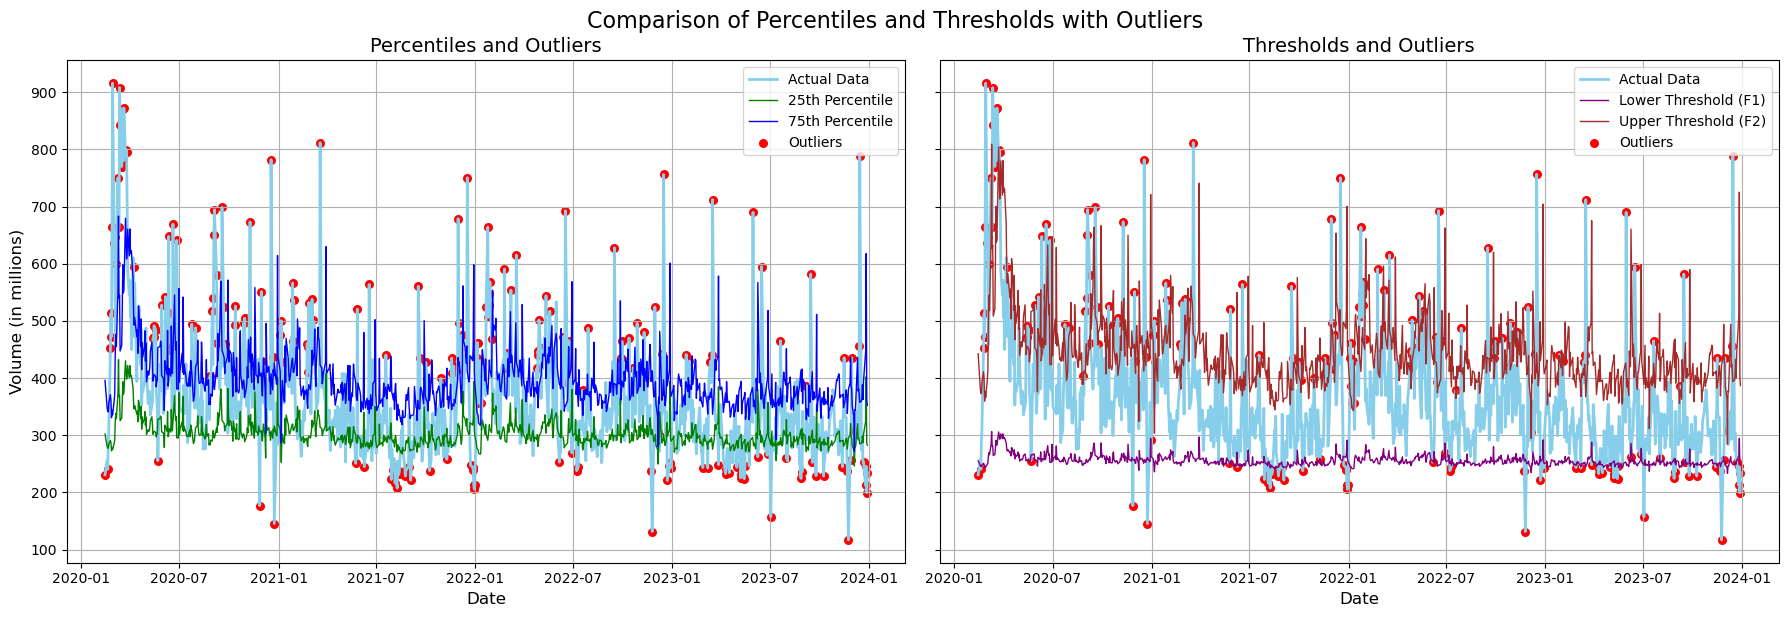

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
axes[0].plot(train2['Date'], train2['Volume'], label='Actual Data', color='skyblue', linewidth=2)
axes[0].plot(train2['Date'], p25, label='25th Percentile', color='green', linewidth=1)
axes[0].plot(train2['Date'], p75, label='75th Percentile', color='blue', linewidth=1)
outliers_left = train2[train2['anomaly_qr'] == 1]
axes[0].scatter(outliers_left['Date'], outliers_left['Volume'], color='red', label='Outliers', s=30)
axes[0].set_title("Percentiles and Outliers", fontsize=14)
axes[0].set_xlabel("Date", fontsize=12)
axes[0].set_ylabel("Volume (in millions)", fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True)
axes[1].plot(train2['Date'], train2['Volume'], label='Actual Data', color='skyblue', linewidth=2)
axes[1].plot(train2['Date'], train2['f1'], label='Lower Threshold (F1)', color='purple', linewidth=1)
axes[1].plot(train2['Date'], train2['f2'], label='Upper Threshold (F2)', color='brown', linewidth=1)
outliers_right = train2[train2['anomaly_qr'] == 1]
axes[1].scatter(outliers_right['Date'], outliers_right['Volume'], color='red', label='Outliers', s=30)
axes[1].set_title("Thresholds and Outliers", fontsize=14)
axes[1].set_xlabel("Date", fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True)
plt.tight_layout()
plt.suptitle("Comparison of Percentiles and Thresholds with Outliers", fontsize=16, y=1.02)
plt.savefig('train_percentiles_thresholds_outliers_comparison.png')

plt.show()

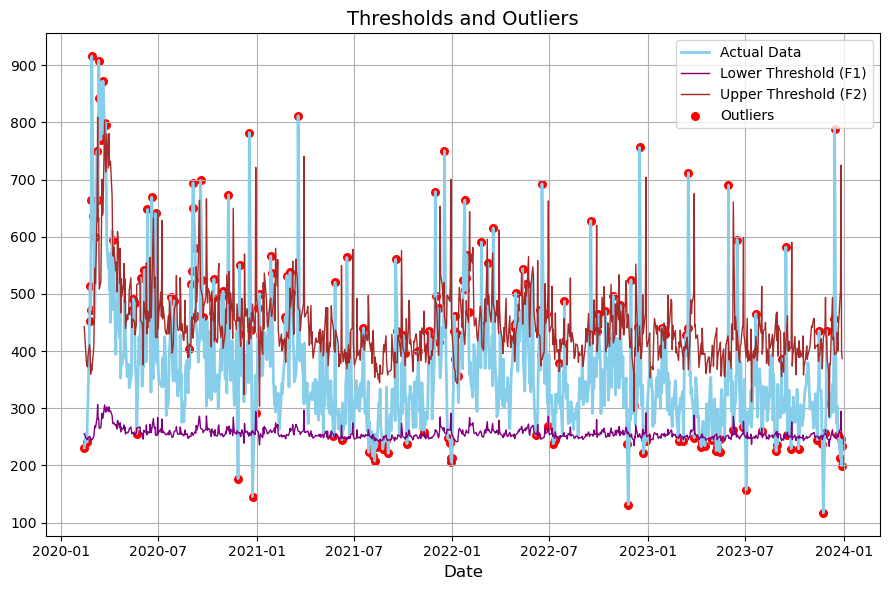

In [33]:
plt.figure(figsize=(9, 6))
plt.plot(train2['Date'], train2['Volume'], label='Actual Data', color='skyblue', linewidth=2)
plt.plot(train2['Date'], train2['f1'], label='Lower Threshold (F1)', color='purple', linewidth=1)
plt.plot(train2['Date'], train2['f2'], label='Upper Threshold (F2)', color='brown', linewidth=1)
outliers_right = train2[train2['anomaly_qr'] == 1]
plt.scatter(outliers_right['Date'], outliers_right['Volume'], color='red', label='Outliers', s=30)
plt.title("Thresholds and Outliers", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
coeffs_25 = q25[1]  
coeffs_75 = q75[1] 
p25 = coeffs_75[0] + coeffs_75[1] * test['lag_7']
p75 = coeffs_25[0] + coeffs_25[1] * test['lag_7']

iqr = p75 - p25
f1 = p25 - k * iqr
f2 = p75 + k * iqr
test['f1'] = f1
test['f2'] = f2
test['anomaly_qr'] = np.where((test['scenario_benchmark'] < test['f1']) |
                               (test['scenario_benchmark'] > test['f2']), 1, 0)
df_test['ID'] = range(1, len(df_test) + 1)
test['ID'] = range(1, len(test) + 1)


test2 = df_test.merge(test, on='ID', how='left')

print(test2.shape)
test2.head()

(210, 40)


,Date,Volume,Flag,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7_x,...,lag_28,lag_29,lag_30,ID,intercept,scenario_benchmark,lag_7_y,f1,f2,anomaly_qr
0,2024-01-02,350.28,0,234.57,199.55,245.53,212.42,252.97,253.12,303.45,...,331.05,334.82,435.54,1,1.0,350.28,303.45,250.466633,407.252536,0
1,2024-01-03,322.01,0,350.28,234.57,199.55,245.53,212.42,252.97,253.12,...,271.12,331.05,334.82,2,1.0,322.01,253.12,245.860444,374.224374,0
2,2024-01-04,380.22,0,322.01,350.28,234.57,199.55,245.53,212.42,252.97,...,237.29,271.12,331.05,3,1.0,380.22,252.97,245.846716,374.125939,1
3,2024-01-05,299.48,0,380.22,322.01,350.28,234.57,199.55,245.53,212.42,...,117.04,237.29,271.12,4,1.0,299.48,212.42,242.135590,347.515727,0
4,2024-01-08,362.20,0,299.48,380.22,322.01,350.28,234.57,199.55,245.53,...,258.34,117.04,237.29,5,1.0,362.20,245.53,245.165809,369.243572,0


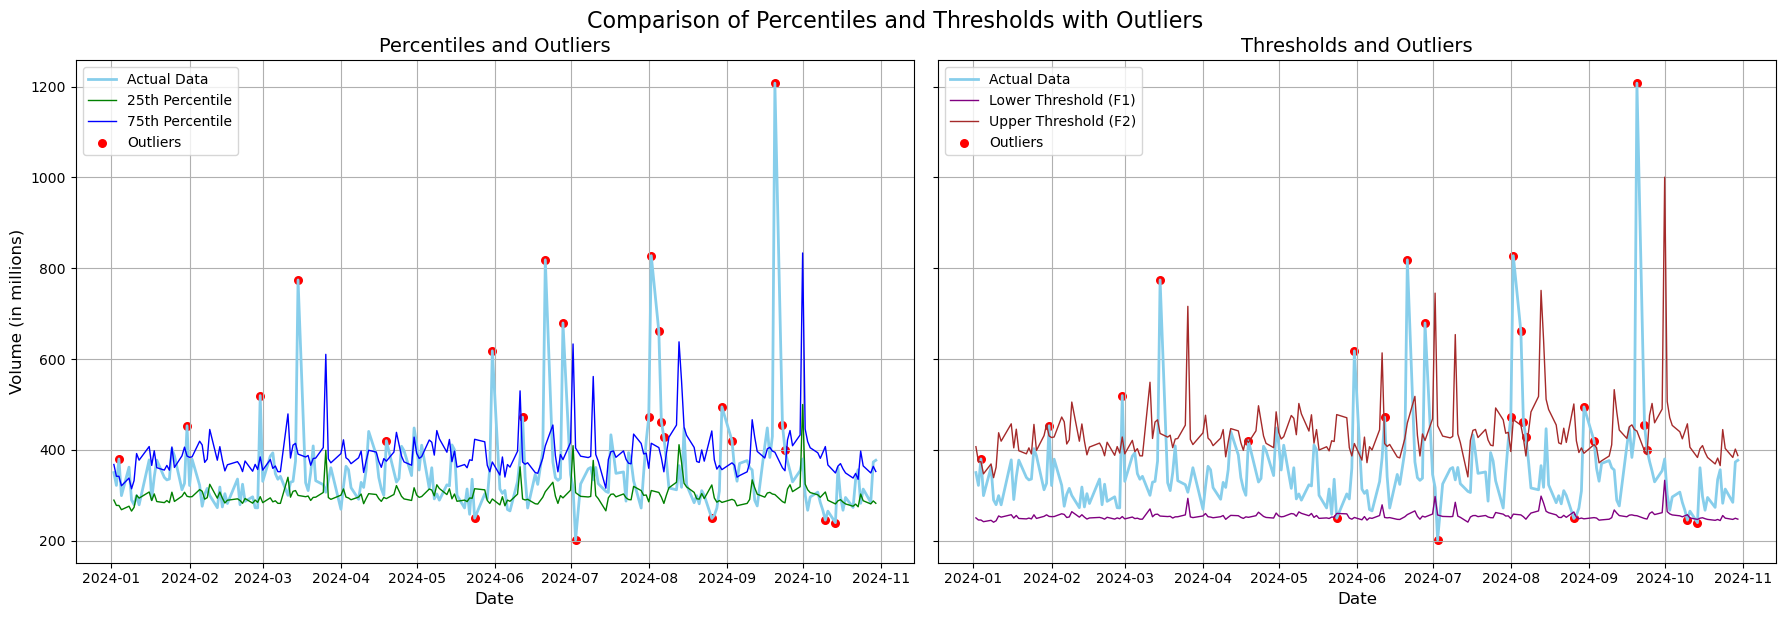

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
axes[0].plot(test2['Date'], test2['Volume'], label='Actual Data', color='skyblue', linewidth=2)
axes[0].plot(test2['Date'], p25, label='25th Percentile', color='green', linewidth=1)
axes[0].plot(test2['Date'], p75, label='75th Percentile', color='blue', linewidth=1)
outliers_left = test2[test2['anomaly_qr'] == 1]
axes[0].scatter(outliers_left['Date'], outliers_left['Volume'], color='red', label='Outliers', s=30)
axes[0].set_title("Percentiles and Outliers", fontsize=14)
axes[0].set_xlabel("Date", fontsize=12)
axes[0].set_ylabel("Volume (in millions)", fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True)
axes[1].plot(test2['Date'], test2['Volume'], label='Actual Data', color='skyblue', linewidth=2)
axes[1].plot(test2['Date'], test2['f1'], label='Lower Threshold (F1)', color='purple', linewidth=1)
axes[1].plot(test2['Date'], test2['f2'], label='Upper Threshold (F2)', color='brown', linewidth=1)
outliers_right = test2[test2['anomaly_qr'] == 1]
axes[1].scatter(outliers_right['Date'], outliers_right['Volume'], color='red', label='Outliers', s=30)
axes[1].set_title("Thresholds and Outliers", fontsize=14)
axes[1].set_xlabel("Date", fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True)
plt.tight_layout()
plt.suptitle("Comparison of Percentiles and Thresholds with Outliers", fontsize=16, y=1.02)
plt.savefig('test_percentiles_thresholds_outliers_comparison.png')

plt.show()

In [36]:
train2['Flag'].value_counts()

Flag
0    834
1    142
Name: count, dtype: int64


Evaluation Metrics:
F1 Score: 0.71
Precision: 0.59
Recall: 0.89
Accuracy: 0.90


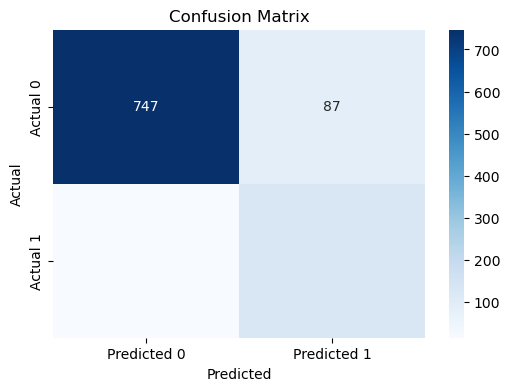

array([[747,  87],
       [ 15, 127]], dtype=int64)

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, accuracy_score

# Extract true labels and predictions
true_labels = train2["Flag"]  # Ground truth
predicted_labels = train2["anomaly_qr"]  # Predictions

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Compute evaluation metrics
f1 = f1_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)

# Print metrics
print("\nEvaluation Metrics:")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")


# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
cm

In [38]:
test2['Flag'].value_counts()

Flag
0    197
1     13
Name: count, dtype: int64


Evaluation Metrics:
F1 Score: 0.70
Precision: 0.54
Recall: 1.00
Accuracy: 0.95


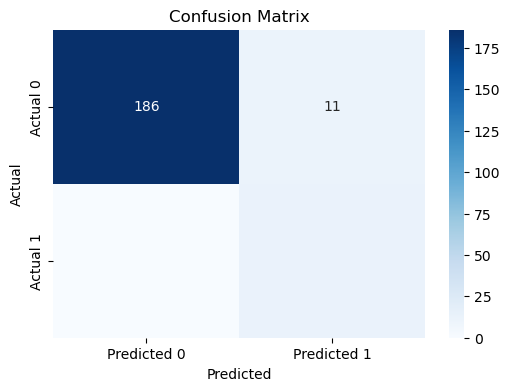

array([[186,  11],
       [  0,  13]], dtype=int64)

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, accuracy_score

# Extract true labels and predictions
true_labels = test2["Flag"]  # Ground truth
predicted_labels = test2["anomaly_qr"]  # Predictions

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Compute evaluation metrics
f1 = f1_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)

# Print metrics
print("\nEvaluation Metrics:")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")


# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
cm